In [1]:
import os
import sys
import csv
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import numpy as np
import scipy
import scipy.spatial.distance
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import utils

vsmdata_home = "vsmdata"
glove_home = "glove.6B"

In [26]:
# word-word representation
ww = utils.build(os.path.join(vsmdata_home, 'imdb-wordword.csv')) # 2998 x 2998 matrix

# word-document representation
wd = utils.build(os.path.join(vsmdata_home, 'imdb-worddoc.csv')) # 2998 x 2998 matrix

# Vector comparison

## 1.1 Euclidean distance

$$\sqrt{\sum_{i=1}^{n}|u_i - v_i|^2}$$

In [62]:
def euclidean(u, v):    
    """Eculidean distance between 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    return scipy.spatial.distance.euclidean(u, v)

In [63]:
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))

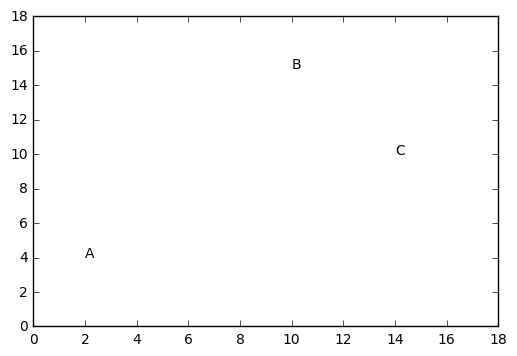

In [64]:
ABC = np.array([
    [ 2.0,  4.0],  # A
    [10.0, 15.0],  # B
    [14.0, 10.0]]) # C

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['A','B','C']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)
plt.show()

In [84]:
print("Euclidean distance between A and B: {}".format(euclidean(ABC[0], ABC[1])))
print("Euclidean distance between B and C: {}".format(euclidean(ABC[1], ABC[2])))
print("Euclidean distance between A and C: {}".format(euclidean(ABC[0], ABC[2])))

Euclidean distance between A and B: 13.601470508735444
Euclidean distance between B and C: 6.4031242374328485
Euclidean distance between A and C: 13.416407864998739


## 1.2 Length normalization

In [67]:
def length_norm(u):
    """L2 norm of the 1d np.array `u`. Returns a float."""
    return u / vector_length(u) 

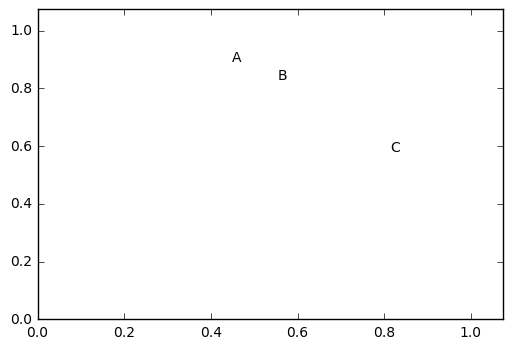

In [69]:
plot_ABC(np.array([length_norm(row) for row in ABC]))
plt.show()

## 1.3 Cosine distance

$$1-\left(\frac{\sum_{i=1}^{n}u_iv_i}{\|u\|\|v\|}\right)$$

In [76]:
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    #return scipy.spatial.distance.cosine(u, v)

    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))

In [83]:
print("Cosine distance between A and B: {}".format(cosine(ABC[0], ABC[1])))
print("Cosine distance between B and C: {}".format(cosine(ABC[1], ABC[2])))
print("Cosine distance between A and C: {}".format(cosine(ABC[0], ABC[2])))

Cosine distance between A and B: 0.007722123286332483
Cosine distance between B and C: 0.06500247368221657
COsine distance between A and C: 0.11621208365293834


In [82]:
np.sum(np.minimum(ABC[0], ABC[1]))

6.0

## 1.3 Matching-based methods

In [85]:
def matching(u, v):    
    """Matching coefficient between the 1d np.array vectors `u` and `v`, 
    which must have the same dimensionality. Returns a float."""
    # The scipy implementation is for binary vectors only. 
    # This version is more general.
    return np.sum(np.minimum(u, v))

In [87]:
print("Matching coefficient between A and B: {}".format(matching(ABC[0], ABC[1])))
print("Matching coefficient between B and C: {}".format(matching(ABC[1], ABC[2])))
print("Matching coefficient between A and C: {}".format(matching(ABC[0], ABC[2])))

Matching coefficient between A and B: 6.0
Matching coefficient between B and C: 20.0
Matching coefficient between A and C: 6.0


In [94]:
def jaccard(u, v):    
    """Jaccard distance between the 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""

    return 1.0 - (np.sum(np.minimum(u, v)) / np.sum(np.maximum(u, v)))

In [93]:
print("Jaccard coefficient between A and B: {}".format(jaccard(ABC[0], ABC[1])))
print("Jaccard coefficient between B and C: {}".format(jaccard(ABC[1], ABC[2])))
print("Jaccard coefficient between A and C: {}".format(jaccard(ABC[0], ABC[2])))

Jaccard coefficient between A and B: 0.76
Jaccard coefficient between B and C: 0.31034482758620685
Jaccard coefficient between A and C: 0.75


### Summary

In [98]:
for m in (euclidean, cosine, jaccard):
    fmt = {'n': m.__name__,  
           'AB': m(ABC[0], ABC[1]), 
           'BC': m(ABC[1], ABC[2])}
    print('%(n)15s(A, B) = %(AB)5.2f %(n)15s(B, C) = %(BC)5.2f' % fmt)

      euclidean(A, B) = 13.60       euclidean(B, C) =  6.40
         cosine(A, B) =  0.01          cosine(B, C) =  0.07
        jaccard(A, B) =  0.76         jaccard(B, C) =  0.31


### Distributional neighbors

In [100]:
def neighbors(word, mat, rownames, distfunc=cosine):    
    """Tool for finding the nearest neighbors of `word` in `mat` according 
    to `distfunc`. The comparisons are between row vectors.
    
    Parameters
    ----------
    word : str
        The anchor word. Assumed to be in `rownames`.
        
    mat : np.array
        The vector-space model.
        
    rownames : list of str
        The rownames of mat.
            
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure  
        between 1d vectors.
        
    Raises
    ------
    ValueError
        If word is not in rownames.
    
    Returns
    -------    
    list of tuples
        The list is ordered by closeness to `word`. Each member is a pair 
        (word, distance) where word is a str and distance is a float.
    
    """
    if word not in rownames:
        raise ValueError('%s is not in this VSM' % word)
    w = mat[rownames.index(word)]
    dists = [(rownames[i], distfunc(w, mat[i])) for i in range(len(mat))]
    return sorted(dists, key=itemgetter(1), reverse=False)

In [127]:
neighbors(word='good', mat=ww[0], rownames=ww[1], distfunc=cosine)[: 5]

[('good', -2.2204460492503131e-16),
 ('pretty', 0.0021237999753120906),
 ('better', 0.0023924324299622324),
 ('but', 0.0024898724881213807),
 ('acting', 0.0026135044630914983)]

In [129]:
neighbors(word='good', mat=ww[0], rownames=ww[1], distfunc=euclidean)[: 5]

[('good', 0.0),
 ('very', 33341.00022494816),
 ('even', 34259.35952407744),
 ('no', 39691.826803512115),
 ("it's", 42606.71065689069)]

### Matrix reweighting

In [131]:
# Normalization
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

Pointwise Mutual Information: $$\log\left({\frac{P(w, c)}{P(w)P(c)}}\right)$$
$$w - word$$
$$c - context$$

In [133]:
def pmi(mat, rownames=None, positive=True):
    """Pointwise Mutual Information with Positive on by default.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
           
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    positive : bool (default: True)
        Implements Positive PMI.
        
    Returns
    -------    
    (np.array, list of str)
       The first member is the PMI-transformed version of `mat`, and the 
       second member is `rownames` (unchanged).
    
    """    
    # Joint probability table:
    p = mat / np.sum(mat, axis=None)
    # Pre-compute column sums:
    colprobs = np.sum(p, axis=0)
    # Vectorize this function so that it can be applied rowwise:
    np_pmi_log = np.vectorize((lambda x : _pmi_log(x, positive=positive)))
    p = np.array([np_pmi_log(row / (np.sum(row)*colprobs)) for row in p])   
    return (p, rownames)

def _pmi_log(x, positive=True):
    """With `positive=False`, return log(x) if possible, else 0.
    With `positive=True`, log(x) is mapped to 0 where negative."""
    val = 0.0
    if x > 0.0:
        val = np.log(x)
    if positive:
        val = max([val,0.0])
    return val

In [153]:
ww_ppmi = pmi(mat=ww[0], rownames=ww[1], positive=True)

In [176]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('excellent', 0.413482748429436),
 ('performances', 0.44391628568702513),
 ('brilliant', 0.45785117509986173),
 ('performance', 0.46856555779383235)]

In [177]:
# Term Frequency–Inverse Document Frequency

def tfidf(mat, rownames=None):
    """TF-IDF 
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
       
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    Returns
    -------
    (np.array, list of str)    
       The first member is the TF-IDF-transformed version of `mat`, and 
       the second member is `rownames` (unchanged).
    
    """
    colsums = np.sum(mat, axis=0)
    doccount = mat.shape[1]
    w = np.array([_tfidf_row_func(row, colsums, doccount) for row in mat])
    return (w, rownames)

def _tfidf_row_func(row, colsums, doccount):
    df = float(len([x for x in row if x > 0]))
    idf = 0.0
    # This ensures a defined IDF value >= 0.0:
    if df > 0.0 and df != doccount:
        idf = np.log(doccount / df)
    tfs = row/colsums
    return tfs * idf

In [181]:
wd_tfidf = tfidf(mat=wd[0], rownames=wd[1])

In [179]:
neighbors(word='superb', mat=wd_tfidf[0], rownames=wd_tfidf[1], distfunc=cosine)[: 5]

[('superb', -2.2204460492503131e-16),
 ('outstanding', 0.72256301656130351),
 ('remain', 0.73606093603489886),
 ('viewed', 0.74639986506462108),
 ('and', 0.74880553661599958)]

### Dimensionality reduction

The general goal of dimensionality reduction is to eliminate rows/columns that are highly correlated while bringing similar things together and pushing dissimilar things apart.

In [186]:
# Latent Semantic Analysis
def lsa(mat=None, rownames=None, k=100):
    """Latent Semantic Analysis using pure scipy.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
           
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    k : int (default: 100)
        Number of dimensions to truncate to.
        
    Returns
    -------    
    (np.array, list of str)
        The first member is the SVD-reduced version of `mat` with 
        dimension (m x k), where m is the rowcount of mat and `k` is 
        either the user-supplied k or the column count of `mat`, whichever 
        is smaller. The second member is `rownames` (unchanged).

    """    
    rowmat, singvals, colmat = svd(mat, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return (trunc, rownames)

In [197]:
gnmat = np.array([
    [1,0,1,0,0,0],
    [0,1,0,1,0,0],
    [1,1,1,1,0,0],
    [0,0,0,0,1,1],
    [0,0,0,0,0,1]], dtype='float64')
gn_rownames = ['gnarly', 'wicked', 'awesome', 'lame', 'terrible']

In [198]:
neighbors(word='gnarly', mat=gnmat, rownames=gn_rownames)

[('gnarly', 2.2204460492503131e-16),
 ('awesome', 0.29289321881345254),
 ('wicked', 1.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

In [201]:
gnmat_lsa = lsa(mat=gnmat, rownames=gn_rownames, k=2)
neighbors(word='gnarly', mat=gnmat_lsa[0], rownames=gnmat_lsa[1])

[('gnarly', 0.0),
 ('wicked', 0.0),
 ('awesome', 0.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

### GloVe word representations